In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# -------------------------------
# CONFIG
# -------------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
FRAME_DIR = "Frames"  # must be pre-extracted
CLASS_NAMES = ['Balassana', 'Bhungassan', 'Padmasan', 'Parvatassan', 'Savasan', 'LeftTrikonasanas', 'RightTrikonasanas']

In [3]:
# -------------------------------
# DATA GENERATORS WITH AUGMENTATION
# -------------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [4]:
train_gen = datagen.flow_from_directory(
    FRAME_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


Found 969 images belonging to 7 classes.


In [5]:
val_gen = datagen.flow_from_directory(
    FRAME_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # needed for confusion matrix
)

Found 238 images belonging to 7 classes.


In [6]:
# -------------------------------
# CLASS WEIGHTS
# -------------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))

In [7]:
# -------------------------------
# MODEL SETUP: MobileNetV2
# -------------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # freeze for transfer learning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(CLASS_NAMES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\yashs\AppData\Local\Temp\ipykernel_14628\8858757.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 24s 3us/step


In [8]:
# -------------------------------
# CALLBACKS
# -------------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint('best_yoga_model.h5', monitor='val_accuracy', save_best_only=True)
]

In [9]:
# -------------------------------
# TRAIN
# -------------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

C:\Users\yashs\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


C:\Users\yashs\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2789 - loss: 2.0781

31/31 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.2823 - loss: 2.0641 - val_accuracy: 0.6092 - val_loss: 1.0881
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.5599 - loss: 1.0243 - val_accuracy: 0.5714 - val_loss: 1.0674
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6527 - loss: 0.8598

31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6534 - loss: 0.8579 - val_accuracy: 0.6176 - val_loss: 0.8732
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6694 - loss: 0.7218 

31/31 ━━━━━━━━━━━━━━━━━━━━ 446s 15s/step - accuracy: 0.6695 - loss: 0.7219 - val_accuracy: 0.6261 - val_loss: 0.7722
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7286 - loss: 0.6213

31/31 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7282 - loss: 0.6213 - val_accuracy: 0.6807 - val_loss: 0.7318
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7781 - loss: 0.5482 - val_accuracy: 0.6555 - val_loss: 0.7699
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7189 - loss: 0.5731 - val_accuracy: 0.6765 - val_loss: 0.7010
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7652 - loss: 0.5027 - val_accuracy: 0.6681 - val_loss: 0.7395
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7202 - loss: 0.5577 - val_accuracy: 0.6597 - val_loss: 0.7407
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7704 - loss: 0.4803 - val_accuracy: 0.6555 - val_loss: 0.7202
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7558 - loss: 0.5047 - val_accuracy: 0.6429 - val_loss: 0.7183


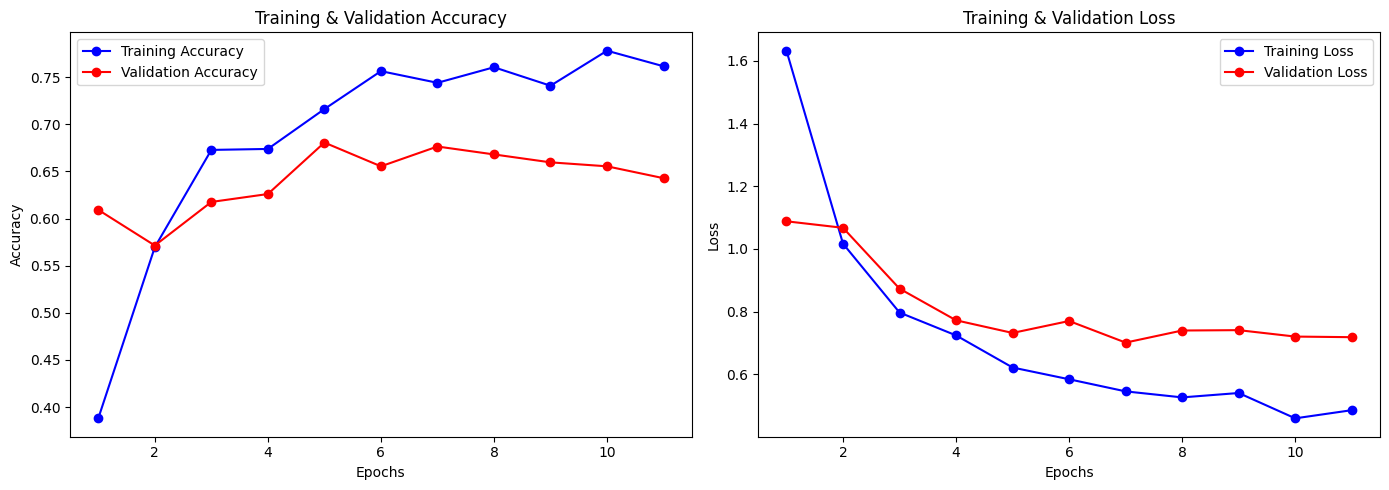

C:\Users\yashs\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


Classification Report:

                   precision    recall  f1-score   support

        Balassana       0.93      0.75      0.83        36
       Bhungassan       0.53      0.77      0.63        35
         Padmasan       0.37      0.93      0.53        28
      Parvatassan       0.72      0.81      0.76        16
          Savasan       1.00      0.85      0.92        33
 LeftTrikonasanas       0.79      0.21      0.33        53
RightTrikonasanas       0.78      0.57      0.66        37

         accuracy                           0.64       238
        macro avg       0.73      0.70      0.66       238
     weighted avg       0.74      0.64      0.63       238



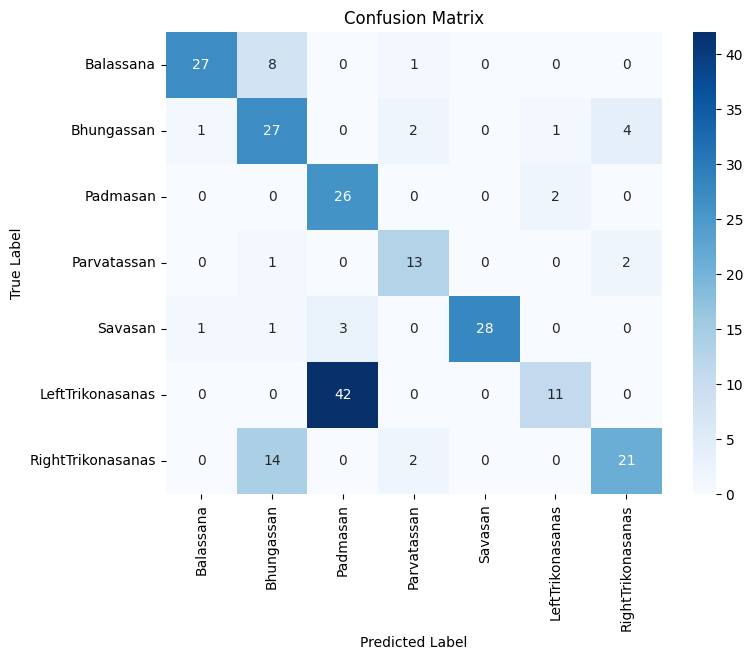

In [10]:
# -------------------------------
# PLOTS
# -------------------------------
def plot_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_curves.png")
    plt.show()

plot_curves(history)

# -------------------------------
# EVALUATION
# -------------------------------
# Predict
y_pred = model.predict(val_gen, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


In [11]:
model.save("yoga_video_classifierV2.h5")